Pclass - Класс билетов

SibSp - Число братьев и сестер / супругов на борту «Титаника»

Parch - Число родителей / детей на борту «Титаника»

Fare - Стоимость проезда для пассажиров

Embarked обозначает порт, в котором пассажир садился на борт. Это категориальная переменная с тремя возможными значениями:
C — Cherbourg (Шербург)
Q — Queenstown (Квинстаун)
S — Southampton (Саутгемптон)

### Import 

In [477]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/titanic-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\alexs\.cache\kagglehub\datasets\yasserh\titanic-dataset\versions\1


In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

from sklearn import ensemble, linear_model, neighbors, svm, tree
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv("C:/Users/alexs/.cache/kagglehub/datasets/yasserh/titanic-dataset/versions/1/Titanic-Dataset.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Preparation

* произведите преобразование типов данных, если нужно;
* исследуйте данные на пропуски, обработайте их (например, заполните какими-то значениями);
* избавьтесь от аномалий, если нужно.


In [7]:
df.shape

(891, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [11]:
f"Дубли - {df.duplicated().sum()}"

'Дубли - 0'

In [13]:
print("Пропуски: ")
df.isna().sum()

Пропуски: 


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

<Axes: xlabel='Sex'>

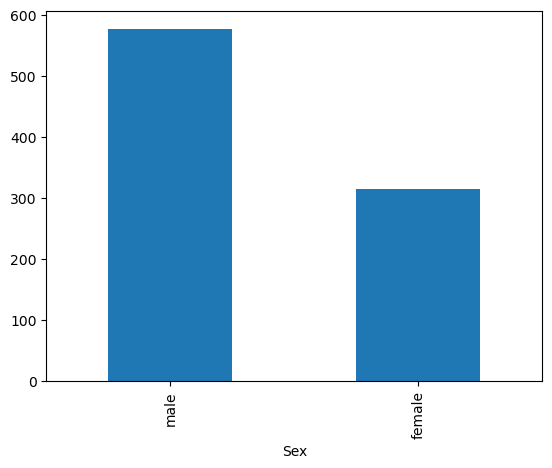

In [15]:
counts = df.Sex.value_counts()

counts.plot(kind="bar")

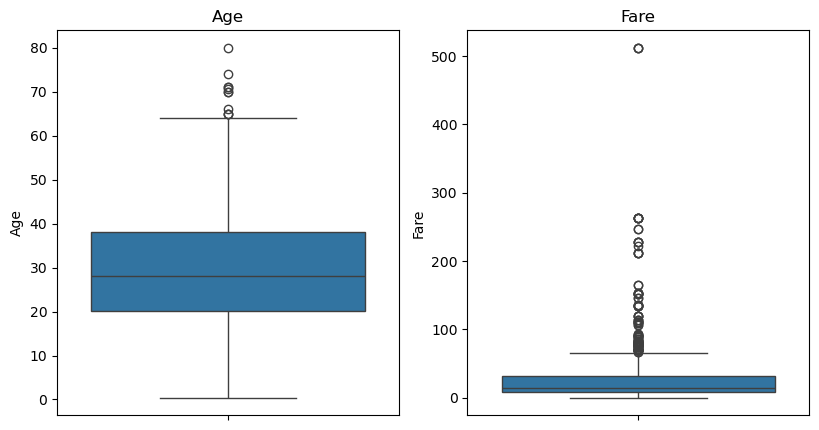

In [17]:
cols = ["Age", "Fare"]

plt.figure(figsize=(15, 5))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

In [18]:
df = df.drop(["Name", "Cabin", "Ticket"], axis=1)

In [20]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,NaN,1,2,23.4500,S


In [23]:
med_age = df.Age.median()
df.Age = df.Age.fillna(med_age)

In [25]:
print("Пропуски: ")
df.isna().sum()

Пропуски: 


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

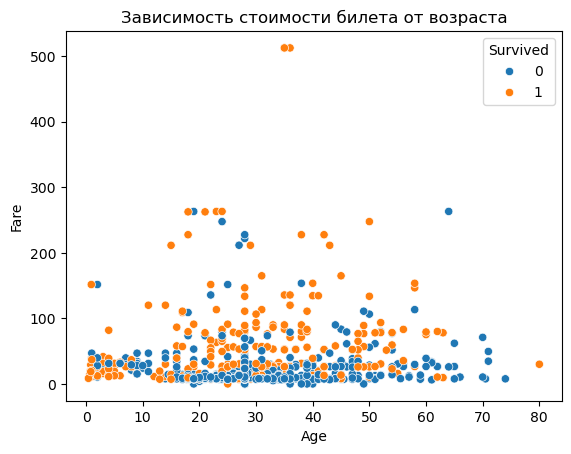

In [27]:
sns.scatterplot(data=df, x='Age', y='Fare', hue='Survived')

plt.title('Зависимость стоимости билета от возраста')
plt.show()

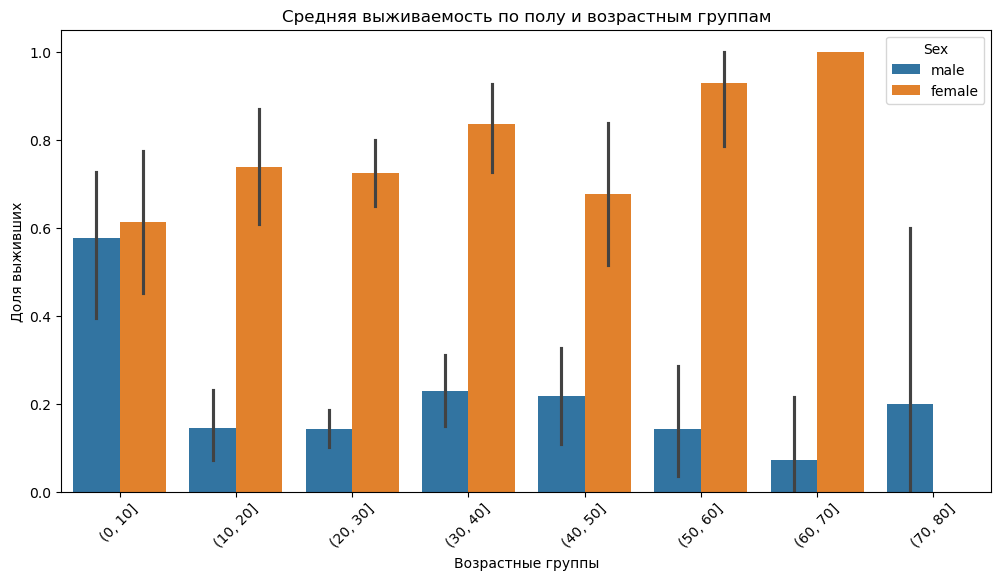

In [28]:
df['AgeGroup'] = pd.cut(df['Age'], bins=range(0, 90, 10))

plt.figure(figsize=(12, 6))
sns.barplot(x='AgeGroup', y='Survived', hue='Sex', data=df)

plt.title('Средняя выживаемость по полу и возрастным группам')
plt.ylabel('Доля выживших')
plt.xlabel('Возрастные группы')
plt.xticks(rotation=45)
plt.show()

In [30]:
df = df.dropna()

In [31]:
df = df.drop(columns=["AgeGroup"], axis=1)

### Feature engineering

Объявите блок Feature engineering. В этом блоке:
* подготовьте категориальные переменные с помощью OneHotEncoder;
* стандартизируйте и нормализуйте переменные, если нужно;
* создайте новые признаки на основе информации в датафрейме (на основе дат, текстовых значений переменных, и так далее);
* удалите неинформативные колонки, которые появились в датасете в результате Feature engineering;
* сформируйте финальный датасет, на котором будет производиться моделирование, и сохраните его в отдельный файл.

In [36]:
# меняем категорийальные на числовые
gender_map = {"female": 0, "male": 1}
df.Sex = df.Sex.map(gender_map)

In [38]:
df = pd.get_dummies(df, columns=['Embarked'], dummy_na=False)

In [40]:
emb_map = {True: 1, False: 0}
cols = ["Embarked_C", "Embarked_Q", "Embarked_S"]

for col in cols:
    df[col] = df[col].map(emb_map)

In [42]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,0,1
2,1,1,0,38.0,1,0,71.2833,1,0,0
3,1,3,0,26.0,0,0,7.9250,0,0,1
4,1,1,0,35.0,1,0,53.1000,0,0,1
5,0,3,1,35.0,0,0,8.0500,0,0,1
...,...,...,...,...,...,...,...,...,...,...
887,0,2,1,27.0,0,0,13.0000,0,0,1
888,1,1,0,19.0,0,0,30.0000,0,0,1
889,0,3,0,28.0,1,2,23.4500,0,0,1


### Modelling

Объявите блок Modelling. В этом блоке:
* сформируйте датасет для обучения; инициализируйте фичи и целевую переменную
(`price_category`); положите их в соответствующие переменные;
* разделите данные на треин и тест;
* объявите модели;
* поработайте с моделями: сделайте тюнинг параметров и выберите лучшую модель с помощью кросс-валидации на тренировочной выборке;
* по результатам кросс-валидации выберите лучшую модель;
* посчитайте значение метрики лучшей модели на тестовой выборке; убедитесь, что модель не переобучилась.


In [45]:
X = df.drop("Survived", axis=1)
y = df.Survived

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [49]:
models = {
    "XGBClassifier": Pipeline([
        ("classifier", XGBClassifier())
    ]),
    "RandomForest": Pipeline([
        ("classifier", ensemble.RandomForestClassifier())
    ]), 
    "LogisticRegression": Pipeline([
        ("classifier", linear_model.LogisticRegression())
    ]), 
    "RidgeClassifier": Pipeline([
        ("classifier", linear_model.RidgeClassifier())
    ]), 
    "KNeighborsClassifier": Pipeline([
        ("classifier", neighbors.KNeighborsClassifier())
    ]), 
    "DecisionTreeClassifier": Pipeline([
        ("classifier", tree.DecisionTreeClassifier())
    ])
}

In [51]:
param_grids = {
    "RandomForest": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__criterion': ["gini", "entropy", "log_loss"],
        'classifier__min_samples_split': [2, 4, 8],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    "LogisticRegression": {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ["lbfgs", "liblinear"],
    },
    "RidgeClassifier": {
        'classifier__alpha': [1.0, 2.0, 4.0],
        'classifier__solver': ["auto", "svd", "lsqr"]
    },
    "KNeighborsClassifier": {
        'classifier__n_neighbors': [5, 10, 15],
        'classifier__algorithm': ["auto", "ball_tree", "brute"],
        'classifier__leaf_size': [30, 50, 100]
    },
    "DecisionTreeClassifier": {
        'classifier__max_depth': [None, 10, 20],
        'classifier__criterion': ["gini", "entropy", "log_loss"],
        'classifier__min_samples_split': [2, 4, 8],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    "XGBClassifier": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__gamma': [0, 1, 5],
    }
}

In [53]:
best_models = {}

for name, model in models.items():
    print(name)
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_weighted')
    grid_search.fit(X_train, y_train)

    best_models[name] = grid_search.best_estimator_
    print(f"Best params: {grid_search.best_estimator_}")
    print(f"F1 cv: {grid_search.best_score_:.3f}")

    y_pred = best_models[name].predict(X_test)
    print(f"F1 test: {f1_score(y_test, y_pred, average='weighted'):.3f}")

XGBClassifier
Best params: Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,


D:\Programs\Anaconda\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
D:\Programs\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Programs\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please al

Best params: Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=50))])
F1 cv: 0.842
F1 test: 0.814
LogisticRegression


D:\Programs\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Programs\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best params: Pipeline(steps=[('classifier', LogisticRegression(C=1))])
F1 cv: 0.783
F1 test: 0.803
RidgeClassifier
Best params: Pipeline(steps=[('classifier', RidgeClassifier(alpha=2.0))])
F1 cv: 0.791
F1 test: 0.796
KNeighborsClassifier
Best params: Pipeline(steps=[('classifier', KNeighborsClassifier(algorithm='brute'))])
F1 cv: 0.677
F1 test: 0.700
DecisionTreeClassifier
Best params: Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=2,
                                        min_samples_split=4))])
F1 cv: 0.798
F1 test: 0.806


In [57]:
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    results.append([name, acc, f1])
    
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])

In [61]:
display(results_df.sort_values('F1 Score', ascending=False))

,Model,Accuracy,F1 Score
0,XGBClassifier,0.829932,0.828532
1,RandomForest,0.816327,0.813928
5,DecisionTreeClassifier,0.812925,0.806233
2,LogisticRegression,0.802721,0.803071
3,RidgeClassifier,0.795918,0.796280
4,KNeighborsClassifier,0.704082,0.699838


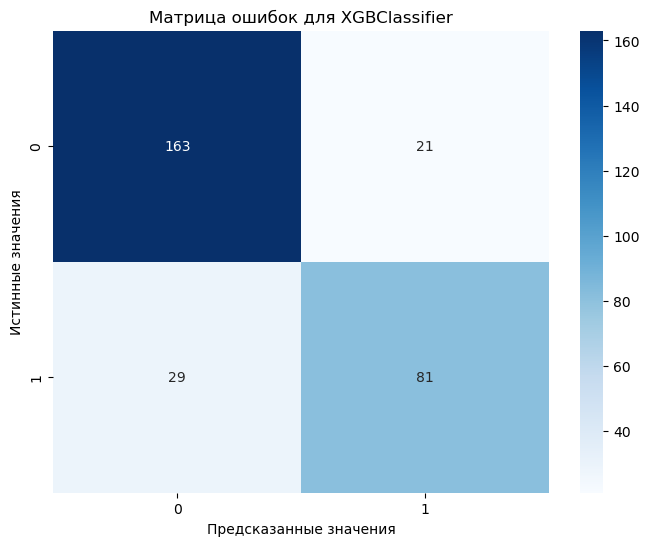

In [101]:
best_model_name = results_df.loc[results_df["F1 Score"].idxmax(), "Model"]
best_model = best_models[best_model_name]
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,  
            yticklabels=best_model.classes_)
plt.title(f'Матрица ошибок для {best_model_name}')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

### Results

* подведите итог: какая модель показала себя лучше всего и будет финальным результатом данного ноутбука;
* обучите эту модель на всём датасете;
* сохраните обученную модель в `pickle`.

In [106]:
final_model = best_model.fit(X, y)

with open("titanic_model.pkl", "wb") as file:
    pickle.dump(final_model, file)